In [6]:
import sys; sys.path.insert(0, '..')
from database.dataset import *

from general_utils.plots import plot_froc, plot_bootstrap_froc
from metrics.metrics import froc_curve, froc_curve_bootstrap, get_froc_df_of_img, get_froc_df_of_many_imgs_features

import matplotlib.pyplot as plt


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import f1_score, roc_auc_score, auc

from sklearn.preprocessing import MinMaxScaler


from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

from xgboost import XGBRFClassifier

In [7]:
db = INBreast_Dataset(
        return_lesions_mask=True,
        level='image',
        max_lesion_diam_mm=1.0,
        partitions=['train', 'validation'],
        extract_patches=False,
        min_breast_fraction_roi=0.5,
        normalize=None,
        n_jobs=-1,
)

In [8]:
features_data, features_data_fns = pd.read_pickle('feature_sets/hough2_all_feat_1pxsize.pkl')

# retrieving each features set column names

fos_cols = [x for x in features_data if 'img' in x and x != 'img_id']
gabor_cols = [x for x in features_data if 'gabor_'in x]
wavelet_cols = [x for x in features_data if  x[:6] == 'patch_' and x != 'patch_coordinates']
haar_cols = [x for x in features_data if  'haar' in x]
features_sets = {'fos':fos_cols, 'gabor':gabor_cols, 'wavelet':wavelet_cols,
                 'haar':haar_cols,
                 'fos+gabor+wavelet+haar':fos_cols+gabor_cols+wavelet_cols+haar_cols}

# adding case_id column
imgid2caseid = db.df[['img_id', 'case_id']].set_index('img_id').to_dict()['case_id']
features_data['case_id'] = [imgid2caseid[imgid] for imgid in features_data['img_id']]

100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


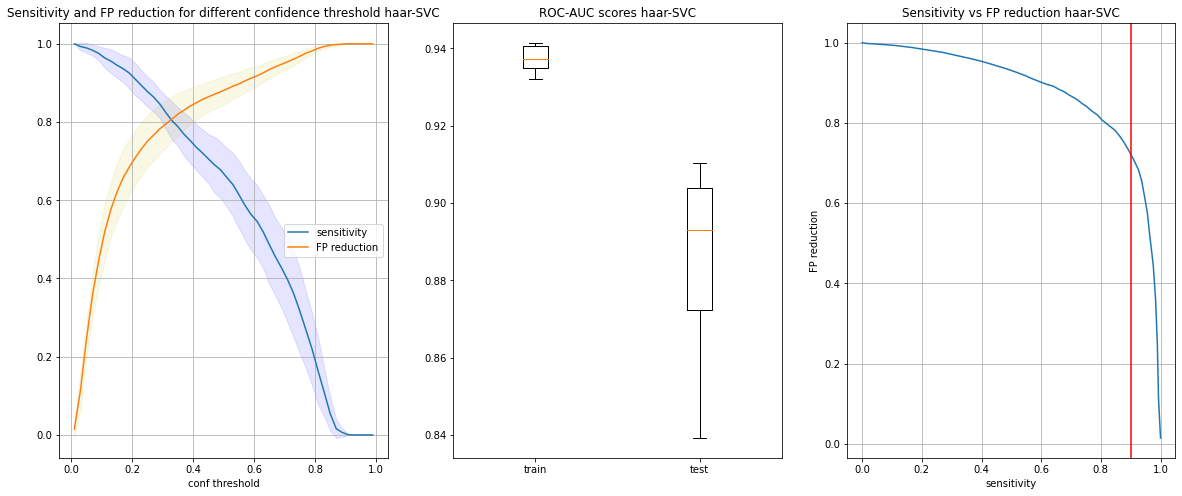

In [11]:
kfolds = 5
FP2TP_rate = 2
desired_sensitivity = 0.9

conf_thresholds = np.linspace(0.01, 0.99)

# splitting data into train/validation case-wise
all_case_ids = features_data.case_id.unique()
kfolds_case_splits = np.array_split(all_case_ids, kfolds)

roc_aucs = []


cascade_pipeline = [{'feature_set':features_sets['fos'], 'clf':RandomForestClassifier(n_estimators=100, max_depth=6, n_jobs=-1), 'descr':'haar-SVC'}]


results = {}

for cascade in cascade_pipeline:

    fpr_sens_curve = []

    # kfold CV
    for valid_case_ids in tqdm(kfolds_case_splits):

        # split data into test
        test_split_mask = features_data.case_id.isin(valid_case_ids)
        
        # split into train and take into account cleaned data with no mC in the borders of the patch
        cleaned_features_data = features_data[~test_split_mask]
        
        # and sampling to a predefined 1:FP2TP_rate TP:FP samples
        positive_mask = (cleaned_features_data.labels>0)
        positive_train_part = cleaned_features_data[positive_mask]
        negative_train_part = cleaned_features_data[~positive_mask].sample(FP2TP_rate*positive_mask.sum()) # INGORING SAMPLING
        
        train_df = pd.concat([positive_train_part, negative_train_part]).sample(frac=1.)
        
        
        
        test_df = features_data[test_split_mask]
        
        train_y = train_df.labels#.astype(int)
        test_y = test_df.labels#.astype(bool)
        
        scaler = MinMaxScaler()
        train_X_scaled = scaler.fit_transform(train_df[cascade['feature_set']].values)
        test_X_scaled = scaler.transform(test_df[cascade['feature_set']].values)
        
        cascade['clf'].fit(train_X_scaled, train_y)

        train_y_predicted = cascade['clf'].predict_proba(train_X_scaled)[:,1]
        test_y_predicted = cascade['clf'].predict_proba(test_X_scaled)[:,1]
        
        roc_aucs.append((roc_auc_score(train_y, train_y_predicted),
                        roc_auc_score(test_y, test_y_predicted)))
        
        sens_fpr = []
        for pred_thr in conf_thresholds:
            test_y_pred_binarized = (test_y_predicted>pred_thr).astype(bool)
            TP = (test_y & test_y_pred_binarized).sum()
            FN = (test_y & ~test_y_pred_binarized).sum()
            FP = (~test_y & test_y_pred_binarized).sum()
            max_FP_possible = (~test_y).sum()
            sens = TP/(TP + FN)
            sens_fpr.append((sens, 1 - FP/max_FP_possible))
            
        fpr_sens_curve.append(sens_fpr)

    # mean and std batch-wise of fpr and sensitivity
    fpr_sens_curve_mean = np.asarray(fpr_sens_curve).mean(axis=0)
    fpr_sens_curve_std = np.asarray(fpr_sens_curve).std(axis=0)


    fig, axs = plt.subplots(1, 3, figsize=(20, 8))

    axs[0].plot(conf_thresholds, fpr_sens_curve_mean[:,0])
    axs[0].fill_between(conf_thresholds, (fpr_sens_curve_mean[:,0]-fpr_sens_curve_std[:,0]), (fpr_sens_curve_mean[:,0]+fpr_sens_curve_std[:,0]), color='b', alpha=.1)

    axs[0].plot(conf_thresholds, fpr_sens_curve_mean[:,1])
    axs[0].fill_between(conf_thresholds, (fpr_sens_curve_mean[:,1]-fpr_sens_curve_std[:,1]), (fpr_sens_curve_mean[:,1]+fpr_sens_curve_std[:,1]), color='y', alpha=.1)

    axs[0].legend(['sensitivity', 'FP reduction'])
    axs[0].grid()
    axs[0].set_xlabel('conf threshold')
    axs[0].set_title(f'Sensitivity and FP reduction for different confidence threshold {cascade["descr"]}')

    axs[1].set_title(f'ROC-AUC scores {cascade["descr"]}')
    axs[1].boxplot(np.array(roc_aucs), labels=['train', 'test'])

    axs[2].plot(fpr_sens_curve_mean[:,0], fpr_sens_curve_mean[:,1])
    axs[2].set_xlabel('sensitivity')
    axs[2].set_ylabel('FP reduction')
    axs[2].set_title(f'Sensitivity vs FP reduction {cascade["descr"]}')
    axs[2].axvline(desired_sensitivity, c='r')
    axs[2].grid()

    plt.show()
    
    results[f'{cascade["descr"]}'] = fpr_sens_curve_mean
